# Library

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [83]:
# Library yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq
from matplotlib import pyplot as plt
import seaborn as sns
import time
from IPython.display import clear_output

In [3]:
# Libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

In [4]:
# Libraries untuk pembangunan model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from keras import Model, layers
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.optimizers import Adam, RMSprop, SGD
from keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from keras.models import Sequential, Model
from keras.applications import MobileNet
from keras.applications.densenet import DenseNet121
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

In [5]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

np.set_printoptions(linewidth=np.inf)

In [6]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.13.0


# Data Loading

In [8]:
# Download kaggle dataset and unzip the file
# !cp kaggle.json ~/.kaggle/

In [9]:
# !chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d tolgadincer/labeled-chest-xray-images

Dataset URL: https://www.kaggle.com/datasets/tolgadincer/labeled-chest-xray-images
License(s): other
100%|█████████████████████████████████████▉| 1.17G/1.17G [03:44<00:00, 6.55MB/s]
100%|██████████████████████████████████████| 1.17G/1.17G [03:44<00:00, 5.60MB/s]


In [87]:
!unzip labeled-chest-xray-images.zip

Archive:  labeled-chest-xray-images.zip
  inflating: chest_xray/test/NORMAL/NORMAL-1049278-0001.jpeg  
  inflating: chest_xray/test/NORMAL/NORMAL-1110860-0001.jpeg  
  inflating: chest_xray/test/NORMAL/NORMAL-11419-0001.jpeg  
  inflating: chest_xray/test/NORMAL/NORMAL-115218-0001.jpeg  
  inflating: chest_xray/test/NORMAL/NORMAL-1160949-0001.jpeg  
  inflating: chest_xray/test/NORMAL/NORMAL-1212407-0001.jpeg  
  inflating: chest_xray/test/NORMAL/NORMAL-1228182-0001.jpeg  
  inflating: chest_xray/test/NORMAL/NORMAL-1283091-0001.jpeg  
  inflating: chest_xray/test/NORMAL/NORMAL-1318320-0001.jpeg  
  inflating: chest_xray/test/NORMAL/NORMAL-1368583-0001.jpeg  
  inflating: chest_xray/test/NORMAL/NORMAL-1430636-0001.jpeg  
  inflating: chest_xray/test/NORMAL/NORMAL-1520670-0001.jpeg  
  inflating: chest_xray/test/NORMAL/NORMAL-152130-0001.jpeg  
  inflating: chest_xray/test/NORMAL/NORMAL-159472-0001.jpeg  
  inflating: chest_xray/test/NORMAL/NORMAL-1608079-0001.jpeg  
  inflating: chest_x

# Data Preparation

In [102]:
# Direktori awal untuk train dan test
train_dir = "chest_xray/train"
test_dir = "chest_xray/test"
 
# Direktori baru untuk dataset gabungan
dataset_dir = "chest_xray/dataset"
print(dataset_dir)

# Buat direktori baru untuk dataset gabungan
os.makedirs(dataset_dir, exist_ok=True)

chest_xray/dataset


In [103]:
for category in os.listdir(train_dir):
    # print(category)
    category_dir = os.path.join(train_dir, category)
    # print(category_dir)
    # print(os.path.isdir(category_dir))
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(dataset_dir, category), dirs_exist_ok=True)
        
for category in os.listdir(test_dir):
    category_dir = os.path.join(test_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(dataset_dir, category), dirs_exist_ok=True)

# Dataset Checking

In [104]:
os.listdir(path_sub)

['NORMAL', 'PNEUMONIA']

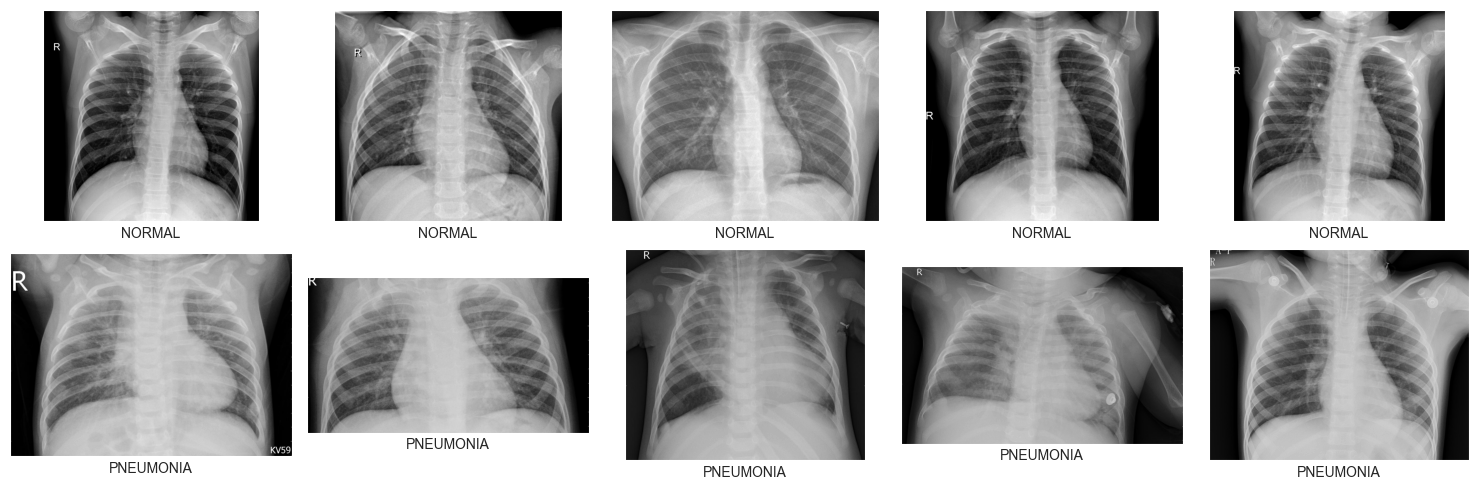

In [105]:
# Membuat kamus yang menyimpan gambar untuk setiap kelas dalam data
lung_image = {}
 
# Tentukan path sumber train
path = "chest_xray/"
path_sub = os.path.join(path, "dataset")
for i in os.listdir(path_sub):
    lung_image[i] = os.listdir(os.path.join(path_sub, i))
 
# Menampilkan secara acak 5 gambar di bawah setiap dari 2 kelas dari data.
# Anda akan melihat gambar yang berbeda setiap kali kode ini dijalankan.
# path_sub = "chest_xray/dataset/"
 
# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(len(lung_image.keys()), 5, figsize=(15, 5))
 
for i, class_name in enumerate(os.listdir(path_sub)):
    images = np.random.choice(lung_image[class_name], 5, replace=False)
 
    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path).convert("L")  # Konversi menjadi skala keabuan
        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])
 
 
fig.tight_layout()

# Plot Distribusi

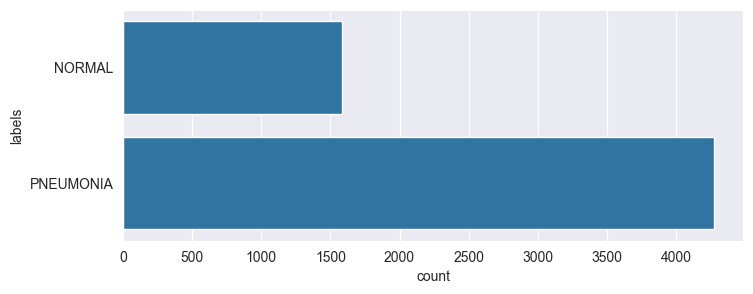

In [106]:
# Definisikan path sumber
lung_path = "chest_xray/dataset/"
 
# Buat daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
file_name = []
labels = []
full_path = []
 
# Dapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai dataframe
for path, subdirs, files in os.walk(lung_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)
 
distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})
 
# Plot distribusi gambar di setiap kelas
Label = distribution_train['labels']
plt.figure(figsize = (8,3))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

# Data Augmentation

In [107]:
# Membuat fungsi untuk melakukan rotasi berlawanan arah jarum jam
def anticlockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    sudut = random.randint(0,180)
    return rotate(img, sudut)
 
# Membuat fungsi untuk melakukan rotasi searah jarum jam
def clockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    sudut = random.randint(0,180)
    return rotate(img, -sudut)
 
# Membuat fungsi untuk membalik gambar secara vertikal dari atas ke bawah
def flip_up_down(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return np.flipud(img)
 
# Membuat fungsi untuk memberikan efek peningkatan kecerahan pada gambar
def add_brightness(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    img = adjust_gamma(img, gamma=0.5,gain=1)
    return img
 
# Membuat fungsi untuk memberikan efek blur pada gambar
def blur_image(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return cv2.GaussianBlur(img, (9,9),0)
 
# Membuat fungsi untuk memberikan efek pergeseran acak pada gambar
def sheared(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    transform = AffineTransform(shear=0.2)
    shear_image = warp(img, transform, mode="wrap")
    return shear_image
 
# Membuat fungsi untuk melakukan pergeseran melengkung pada gambar
def warp_shift(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    transform = AffineTransform(translation=(0,40))
    warp_image = warp(img, transform, mode="wrap")
    return warp_image

In [109]:
transformations = { 'rotate anticlockwise': anticlockwise_rotation,
                    'rotate clockwise': clockwise_rotation,
                    'warp shift': warp_shift,
                    'blurring image': blur_image,
                    'add brightness' : add_brightness,
                    'flip up down': flip_up_down,
                    'shear image': sheared
                  }

images_path="chest_xray/dataset/NORMAL" # Path untuk gambar asli
augmented_path="chest_xray/dataset/NORMAL" # Path untuk gambar yang sudah diaugmentasi
images=[] # Penyimpanan gambar yang telah melalui pra-pemrosesan
 
# Baca nama gambar dari folder dan tambahkan path ke dalam array "images"
for im in os.listdir(images_path):
    images.append(os.path.join(images_path,im))
 
# Jumlah gambar yang akan ditambahkan dengan hasil transformasi augmentasi, jumlahnya disesuaikan sesuai kebutuhan
# Variabel untuk melakukan iterasi sampai jumlah gambar yang ditentukan dalam images_to_generate
# images_to_generate=2000
# i=1

# Yasir :
# Untuk memastikan jumlah data seimbang, data paru normal akan diaugmentasi hingga sama dengan jumlag data pneumonia
pneumonia = 'chest_xray/dataset/PNEUMONIA/'
images_to_generate = len(os.listdir(pneumonia))
normal = 'chest_xray/dataset/NORMAL/'
i = len(os.listdir(normal))

 
while i<=images_to_generate:
    image=random.choice(images)
    try:
        original_image = io.imread(image)
        transformed_image=None
        n = 0      # Variabel untuk melakukan iterasi sampai jumlah transformasi yang akan diterapkan
        transformation_count = random.randint(1, len(transformations)) # Pilih jumlah transformasi acak yang akan diterapkan pada gambar
 
        while n <= transformation_count:
            key = random.choice(list(transformations)) # Secara acak memilih dan memanggil metode
            transformed_image = transformations[key](original_image)
            n = n + 1
            clear_output(wait=True)
            print(f"Augmentaion on : {image} with {transformations[key]}")
            time.sleep(0.01)
 
        new_image_path= "%s/augmented_image_%s.jpg" %(augmented_path, i)
        transformed_image = img_as_ubyte(transformed_image)  # Mengonversi gambar ke format byte yang tidak ditandatangani, dengan nilai dalam [0, 255]
        cv2.imwrite(new_image_path, transformed_image)  # Simpan hasil transformasi augmentasi pada gambar ke path yang ditentukan
        i =i+1
    except ValueError as e:
        print('could not read the',image ,':',e,'hence skipping it.')

Augmentaion on : chest_xray/dataset/NORMAL/NORMAL-6960239-0002.jpeg with <function add_brightness at 0x70da7ebdf640>


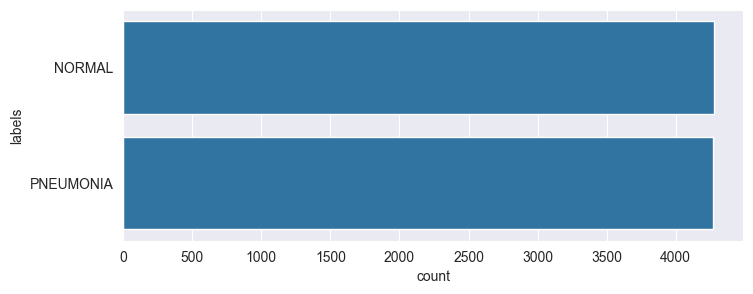

In [110]:
# Definisikan path sumber
lung_path = "chest_xray/dataset/"
 
# Buat daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
file_name = []
labels = []
full_path = []
 
# Dapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai dataframe
for path, subdirs, files in os.walk(lung_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)
 
distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})
 
# Plot distribusi gambar di setiap kelas
Label = distribution_train['labels']
plt.figure(figsize = (8,3))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

# Data Splitting

In [111]:
# Panggil variabel mypath yang menampung folder dataset gambar
mypath= 'chest_xray/dataset/'
 
file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)
 
# Memasukkan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapi
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

labels
NORMAL       4274
PNEUMONIA    4273
dtype: int64

In [115]:
# Variabel yang digunakan pada pemisahan data ini di mana variabel x = data path dan y = data labels
X = df['path']
y = df['labels']
 
# Split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=300)
print(f"Data Test : {len(y_train)}\nData Test : {len(y_test)}")

Data Test : 6837
Data Test : 1710


In [116]:
# Menyatukan ke dalam masing-masing dataframe
df_train = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_test = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})

In [121]:
# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_train, df_test], ignore_index=True)
 
print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')
 
# Cek sampel data
print(df_all.sample(5))
 
# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = "chest_xray/dataset/"
# Membuat variabel Dataset, tempat menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "Dataset-Final/"


set    labels   
test   NORMAL        827
       PNEUMONIA     883
train  NORMAL       3447
       PNEUMONIA    3390
dtype: int64 


                                                   path     labels    set
7314  chest_xray/dataset/PNEUMONIA/BACTERIA-5702325-...  PNEUMONIA   test
5145  chest_xray/dataset/PNEUMONIA/BACTERIA-391346-0...  PNEUMONIA  train
1932  chest_xray/dataset/NORMAL/augmented_image_4176...     NORMAL  train
2122  chest_xray/dataset/PNEUMONIA/BACTERIA-7718116-...  PNEUMONIA  train
8316  chest_xray/dataset/PNEUMONIA/BACTERIA-385176-0...  PNEUMONIA   test


In [127]:
for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])
 
    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))
 
    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)
 
    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]